# Psi4 Tutorial 02: Hartree–Fock Theory

In this tutorial you will explore Hartree-Fock computations with psi4.

As usual, we start with the important stuff: import psi4

In [1]:
import psi4

## Ne atom

Let us start by performing a computation on the Ne atom using Hartree–Fock theory and the cc-pVDZ basis set

In [ ]:
psi4.core.set_output_file('output.ar.dat', False)

ar_geom = psi4.geometry("""
0 1
Ar 0.0 0.0 0.0
""")

energy = psi4.energy('scf/cc-pvdz', molecule=ar_geom)

To analyze the results of a Hartree–Fock computation, we can look at the output file under the section labeled `==> Post-Iterations <==`.

You should be able to find this block of text
```
  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1Ag   -32.765665     2Ag    -1.918810     1B2u   -0.832115  
       1B3u   -0.832115     1B1u   -0.832115  

    Virtual:                                                              

       2B3u    1.694660     2B2u    1.694660     2B1u    1.694660  
       3Ag     2.159507     1B1g    5.197106     4Ag     5.197106  
       1B3g    5.197106     1B2g    5.197106     5Ag     5.197106  
```

In [ ]:
!cat output.ar.dat

The energies of the occupied orbitals are approximately related to ionization energies. Let's compute a few and convert them to units of eV

In [ ]:
print(f'The 2p orbital ionization potential is {0.832115 * 27.211:.2f} eV')
print(f'The 1s orbital ionization potential is {32.765665 * 27.211:.2f} eV')

We can now compare the orbital energies to those from the *NIST Atomic Spectra Database Ionization Energies*

https://physics.nist.gov/PhysRefData/ASD/ionEnergy.html

Search for Ne I. The reported ionization energy to form Ne+ in the 2p$^5$ configuration is 21.564540 eV. This value is close to our predicted 22.54 eV.

In [ ]:
print(f'The 3p orbital ionization potential is {0.588024  * 27.211:.2f} eV')
print(f'The 1s orbital ionization potential is {118.606289 * 27.211:.2f} eV')

## The orbitals of water

Next, we will compute the Hartree–Fock optimized geometry and orbitals of water. We are also going to generate orbital plots, and to do so we will call the function `psi4.cubeprop`. We will specify the number of MOs to plot otherwise we might end up generating too much data to store on disk! In this case we want to be able to see all the core + valence orbitals, which are 7 in total:
```
===========================================================
atom     core + valence orbitals     orbitals per atom type
-----------------------------------------------------------
 O     1s, 2s, 2p = 1 + 1 + 3 = 5              5
 H             1s = 1                          2
-----------------------------------------------------------
                                               7
===========================================================
```

In [5]:
psi4.core.set_output_file('output.h2o.dat', False)

mol = psi4.geometry("""
0 1
O
H 1 1.0
H 1 1.0 2 104.5
""")

psi4.set_options({
    'CUBEPROP_TASKS': ['ORBITALS','DENSITY'],
    'CUBEPROP_ORBITALS': [1,2,3,4,5,6,7],
    'reference' : "RHF"
})

e, wfn = psi4.energy('scf/cc-pvdz',mol=mol,return_wfn=True)

# e, wfn = psi4.energy('scf/cc-pvdz',molecule=h2o_geom,return_wfn=True)
psi4.cubeprop(wfn)

In [7]:
wfn.epsilon_a().nph

(array([-20.55785023,  -1.31618593,  -0.55872304,   0.1780159 ,
          0.81614408,   1.16634735,   1.4528803 ,   1.87740921,
          2.3886313 ,   3.45460762,   3.8219673 ]),
 array([1.46653353, 3.29836408]),
 array([-0.49037528,  1.19868616,  1.66851524,  3.24943365]),
 array([-0.67707619,  0.24948637,  0.76031162,  1.25657656,  1.89044252,
         2.35507556,  4.09933494]))

In [18]:
import fortecubeview
fortecubeview.plot()

CubeViewer: listing cube files from the directory .
Reading 18 cube files


/Users/fevange/miniforge3/envs/forte/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('Density (alpha)', 'Density (beta)', 'Density…

In [ ]:
!cat output.h2o.dat

Orbital energies for water can be found on the NIST website: https://physics.nist.gov/cgi-bin/Ionization/table.pl?ionization=H2O


```
Molecular Orbital Constants
Orbital	Binding energy (eV)
  2a1	     36.88
  1b2	     19.83
  3a1	     15.57
  1b1	     12.61
```

These compare well with the values predicted by theory

In [20]:
print(f'The 2A1 orbital ionization potential is {1.342334 * 27.211:.2f} eV')
print(f'The 1B2 orbital ionization potential is {0.705499 * 27.211:.2f} eV')
print(f'The 3A1 orbital ionization potential is {0.568413 * 27.211:.2f} eV')
print(f'The 1B1 orbital ionization potential is {0.493926 * 27.211:.2f} eV')

The 2A1 orbital ionization potential is 36.53 eV
The 1B2 orbital ionization potential is 19.20 eV
The 3A1 orbital ionization potential is 15.47 eV
The 1B1 orbital ionization potential is 13.44 eV


## Best practices for generating MOs

Several options control the generation of the cube files used to represent 3D orbital information. The most useful are:

- `CUBEPROP_TASKS`. This option tells psi4 what type of quantity to plot. Options include: `DENSITY` (electron density), `ESP` (electrostatic potential), `ORBITALS` (orbitals), `BASIS_FUNCTIONS` (atomic basis functions), `FRONTIER_ORBITALS` (HOMO, LUMO). You can specify multiple tasks by passing a list, e.g.:
```python
psi4.set_options({CUBEPROP_TASKS : ['ORBITALS', 'DENSITY'], ...})
```

- `CUBEPROP_FILEPATH`. The path where the cube file are stored. The default is the current directory (the one in which you are running the jupyter notebook). It is convenient to keep files organized to store the cube files in a different directory.

- `CUBEPROP_ORBITALS`. This is List of orbital indices for which cube files are generated (1-based). Positive numbers stand for alpha orbitals, negative numbers for beta. If this option is not probided **all orbitals are computed!** (unless you set `'CUBEPROP_TASKS' : ['FRONTIER_ORBITALS']`)

- `CUBIC_GRID_SPACING`. This option specifies the spacing of the grid in the X, Y, Z directions. Defaults to 0.2 bohr each. To make the grid finer you cand od
```python
psi4.set_options({CUBIC_GRID_SPACING : [0.1,0.1,0.1], ...})
```

- `CUBIC_GRID_OVERAGE`. This option controls the spatial extent (in bohr) of the grid. The fefault is 4.0 bohr in each direction. If your orbitals get cut out you can try to make the overage bigger
```python
psi4.set_options({CUBIC_GRID_OVERAGE : [6.0,6.0,6.0], ...})
```


This example shows a good way to perform a computation and plot the orbitals

In [31]:
# make a directory called h2_mos where we will store all the cube files
!mkdir h2_mos

# setup computation
psi4.core.set_output_file('output.h2.dat', False)

h2_geom = psi4.geometry("""
H
H 1 1.74
""")

psi4.set_options({
    'CUBEPROP_TASKS': ['ORBITALS','DENSITY'],
    'CUBEPROP_ORBITALS': [1,2,3,4],
    'CUBEPROP_FILEPATH': 'h2_mos',
    
})

# run the energy computation
e, wfn = psi4.energy('scf/cc-pvdz',molecule=h2_geom,return_wfn=True)

# generate the cube files
psi4.cubeprop(wfn)

mkdir: h2_mos: File exists


If we list the files in the folder `h2_mos` with the command `ls` we should find all the cube files for the density (Da.cube, Db.cube, ...) and the orbitals (Psi_a_1_1-Ag.cube,...), plus the geometry of the molecule (geom.xyz).

In [22]:
!ls -l h2_mos

total 16648
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062753 Sep 14 15:07 Da.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062753 Sep 14 15:07 Db.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062744 Sep 14 15:07 Ds.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062753 Sep 14 15:07 Dt.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062751 Sep 14 15:07 Psi_a_1_1-Ag.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062760 Sep 14 15:07 Psi_a_2_1-B1u.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062761 Sep 14 15:07 Psi_a_3_2-Ag.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users  1062762 Sep 14 15:07 Psi_a_4_2-B1u.cube
-rw-r--r--  1 fevange  EMORYUNIVAD\Domain Users      159 Sep 14 15:07 geom.xyz


Now we can plot the orbitals, customizing their look!

Try some of the color schemes: `colorschemes = ['emory', 'national', 'bright', 'electron', 'wow']`

Some of the argument passed to the plot function are trivial. An interesting one is `sumlevel`. This controls the fraction of electron density (a number between 0 and 1) that we want to plot. The default is 0.85 (85%). This means that the contour plotted contains 85% of the electron density for a given orbital (or the total density).

In [28]:
fortecubeview.plot('h2_mos',sumlevel=0.75,colorscheme='electron',width=600,height=400,font_family='Times New Roman')

CubeViewer: listing cube files from the directory h2_mos
Reading 8 cube files


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('Density (alpha)', 'Density (beta)', 'Density…

## A script to monitor SCF convergence

The following function can be used to plot the energy convergence of the Hartree–Fock procedure. Just pass the name of the output file that you want to analyze

In [29]:
import matplotlib.pyplot as plt

def plot_scf_energy(filename):
    """
    Function to plot the energy during a SCF computation.

    Usage: plot_scf_energy(filename)

    Inputs: name of psi4 output file from SCF calculation
    filename: name

    Output: plot of energy values from each SCF step
    """

    with open(filename) as f:
        energy_values = []
        for line in f:
            if line.strip().startswith('@DF-') or line.strip().startswith('@RHF') or line.strip().startswith('@RKS'):
                energy_values.append(float(line.split()[3]))
        iteration = list(range(len(energy_values)))
    
    plt.plot(iteration,energy_values,'o')
    plt.xlabel('iteration')
    plt.ylabel('energy (Eh)')
    plt.title(' SCF Convergenge')
    plt.show()

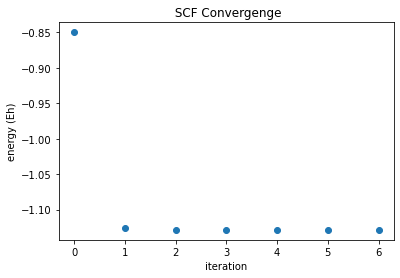

In [30]:
plot_scf_energy('output.h2.dat')

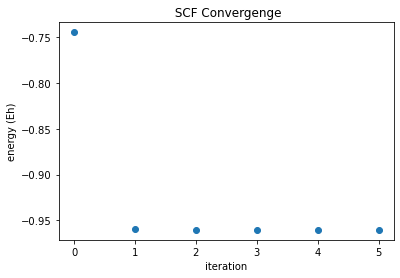

In [32]:
plot_scf_energy('output.h2.dat')